# Multi-session analysis
This notebook demonstrate how to combine different xarray dataset together and perform group-level analysis

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions
from trialexp.process.group_analysis.plot_utils import plot_group_average, plot_subject_average, plot_subject_comparison
import itertools

## Build dataframe containing the metadata of all sessions

`build_session_info` will extract information from the by_sessions folder and build a dataframe for further filtering


In [2]:
#specify the location of the by_sessions folder here
root_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'

df_session_info = build_session_info(root_path, load_pycontrol=True, pycontrol_parameters=['hold_time_required_ms', 'US_delay_ms'], param_extract_method='tail')
df_session_info['hold_time_required_ms']=df_session_info['hold_time_required_ms'].astype(float)
df_session_info['US_delay_ms'] = df_session_info['US_delay_ms'].astype(float)

## Loading data

`filter_sessions` provide a set of functions for filtering recording sessions. For details on how to use it, please consult its documentation

In [3]:
#select the last 5 sessions from animal kms058
df_sel = filter_sessions(df_session_info,session_no=3, 
                         animal_id=['TT001', 'TT002','TT005', 'RE606','RE607'],
                         session_method='tail', 
                         task_name='reaching_go_spout_bar_nov22', 
                         query='hold_time_required_ms >= 1000 and US_delay_ms>=500')
df_sel.sort_values(['animal_id','expt_datetime'])

,animal_id,expt_datetime,session_id,task_name,path,session_no,US_delay_ms,hold_time_required_ms
186,RE606,2023-06-02 10:40:01,RE606-2023-06-02-104001,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,7.0,500.0,1000.0
300,RE606,2023-06-05 12:09:00,RE606-2023-06-05-120900,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,8.0,500.0,1000.0
331,RE606,2023-06-06 10:03:31,RE606-2023-06-06-100331,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,9.0,500.0,1000.0
273,RE607,2023-06-05 13:12:32,RE607-2023-06-05-131232,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,10.0,500.0,1000.0
151,RE607,2023-06-06 11:17:51,RE607-2023-06-06-111751,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,11.0,500.0,1000.0
238,TT001,2023-06-02 16:36:05,TT001-2023-06-02-163605,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,8.0,500.0,1000.0
251,TT001,2023-06-05 16:16:10,TT001-2023-06-05-161610,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,9.0,500.0,1000.0
356,TT001,2023-06-06 15:59:28,TT001-2023-06-06-155928,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,10.0,500.0,1000.0
286,TT002,2023-06-02 15:54:42,TT002-2023-06-02-155442,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,9.0,500.0,1000.0
303,TT002,2023-06-05 15:49:32,TT002-2023-06-05-154932,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,10.0,500.0,1000.0


`load_and_conat_dataset` is a helper functions that combines multiple sessions of dataset together

In [4]:
paths = df_sel.path
ds_combined = load_and_concat_dataset(paths)

  0%|          | 0/14 [00:00<?, ?it/s]

Concating datasets...


In [5]:
ds_combined

<xarray.Dataset>
Dimensions:                           (trial_nb: 508, event_time: 500,
                                       session_id: 14)
Coordinates:
  * trial_nb                          (trial_nb) int64 1 2 3 4 ... 506 507 508
  * event_time                        (event_time) int64 -1995 -1985 ... 2995
  * session_id                        (session_id) object 'RE606-2023-06-02-1...
Data variables: (12/21)
    uid                               (session_id, trial_nb) object 'RE606_20...
    trigger                           (session_id, trial_nb) object 'hold_for...
    valid                             (session_id, trial_nb) float64 1.0 ... nan
    Go_to_get_water                   (session_id, trial_nb) float64 0.0 ... nan
    US_end_timer                      (session_id, trial_nb) float64 0.0 ... nan
    break_after_abort                 (session_id, trial_nb) float64 0.0 ... nan
    ...                                ...
    success                           (session_id, trial_nb) float64 0.0 ... nan
    trial_outcome                     (session_id, trial_nb) object 'no_reach...
    hold_for_water_zscored_df_over_f  (session_id, trial_nb, event_time) float64 ...
    first_bar_off_zscored_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_zscored_df_over_f     (session_id, trial_nb, event_time) float64 ...
    last_bar_off_zscored_df_over_f    (session_id, trial_nb, event_time) float64 ...

## Plot figures

Using 385 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 385 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 294 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 292 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


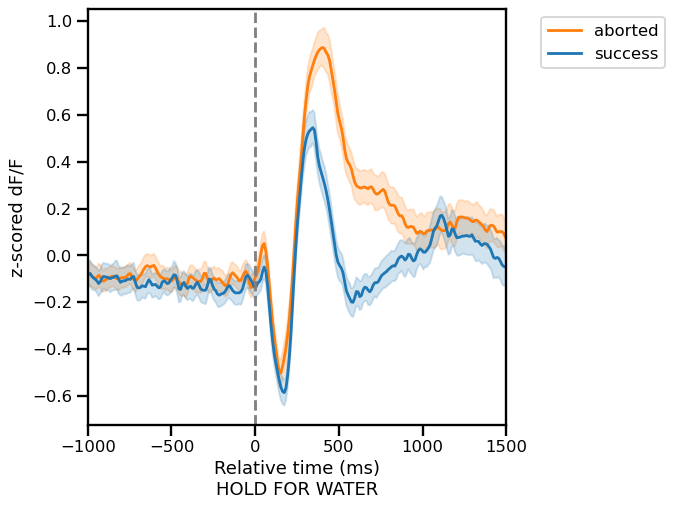

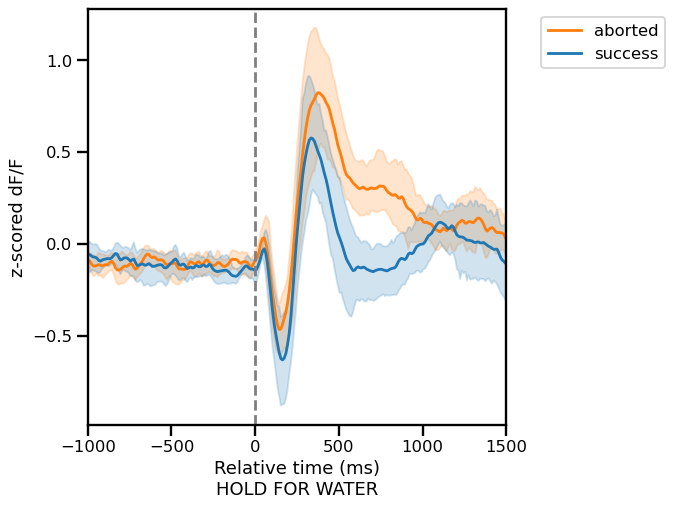

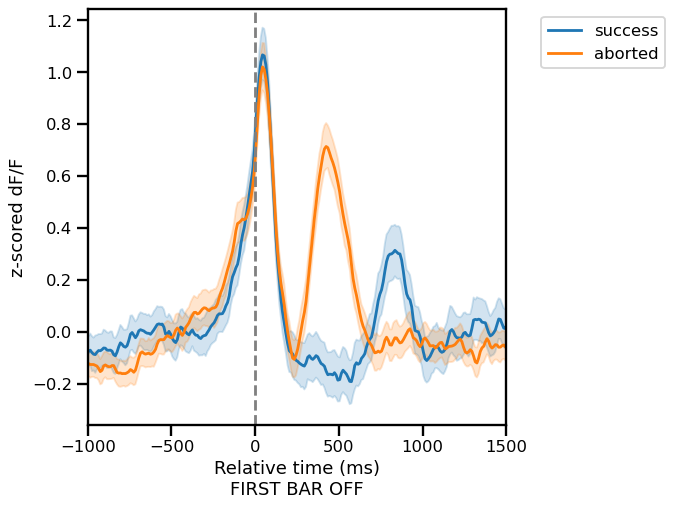

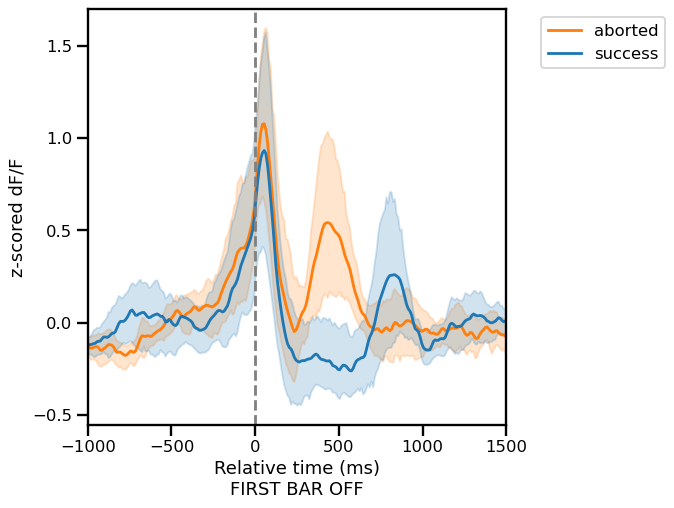

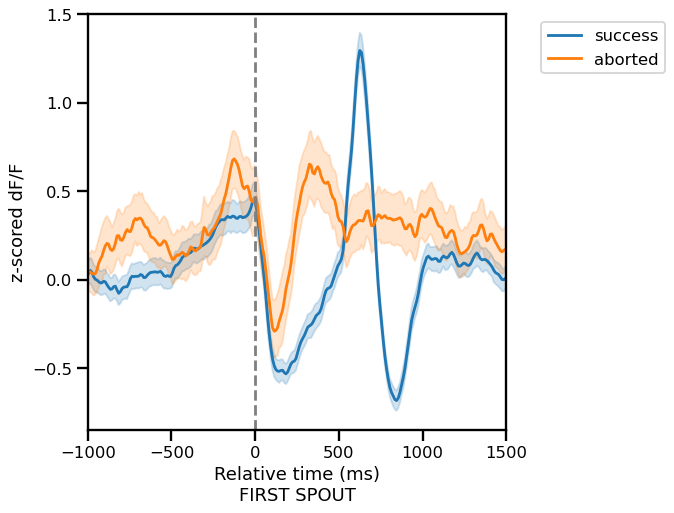

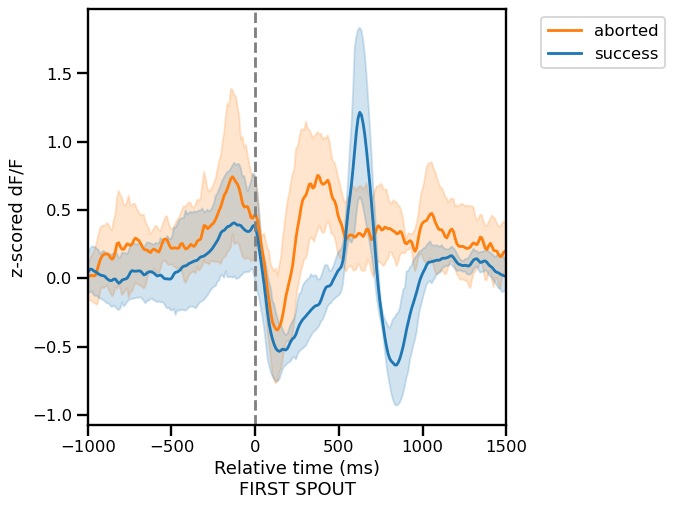

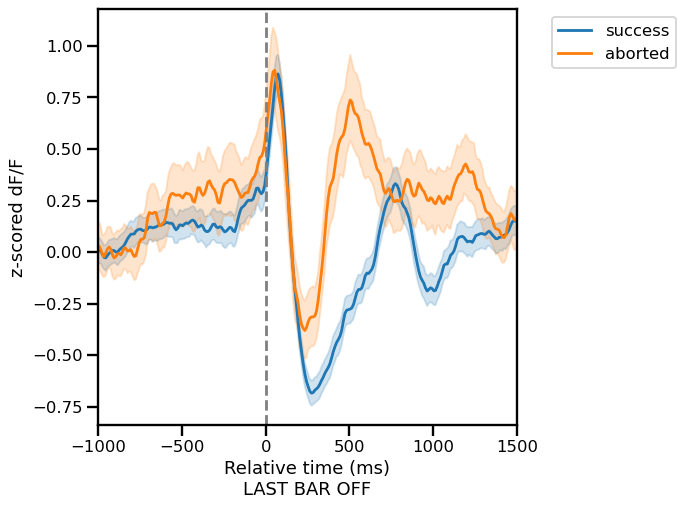

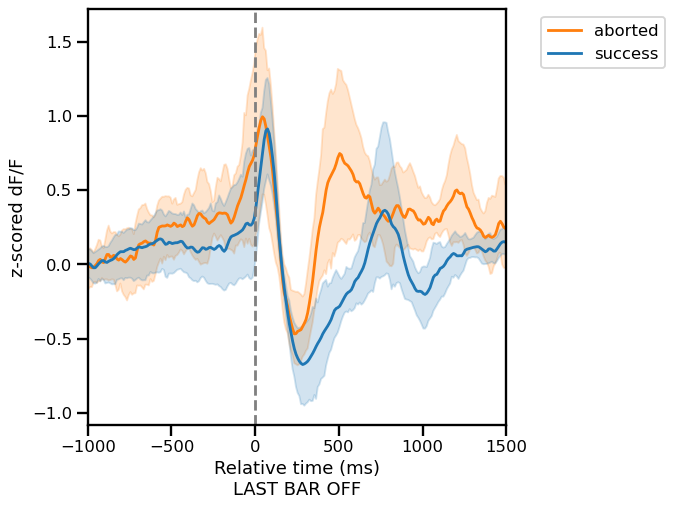

In [6]:
sns.set_context('talk',font_scale=0.8)

animal_id = df_sel[['animal_id','session_id', 'expt_datetime']]

vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']
average_mode = ['equal_subsample', 'mean_of_mean']

for v, mode in itertools.product(vars_to_plot, average_mode):
    fig,ax = plot_group_average(ds_combined, animal_id, v, average_method=mode)
    fig.savefig(f'figures/ACh_group_average_{v}_{mode}.png', bbox_inches='tight')

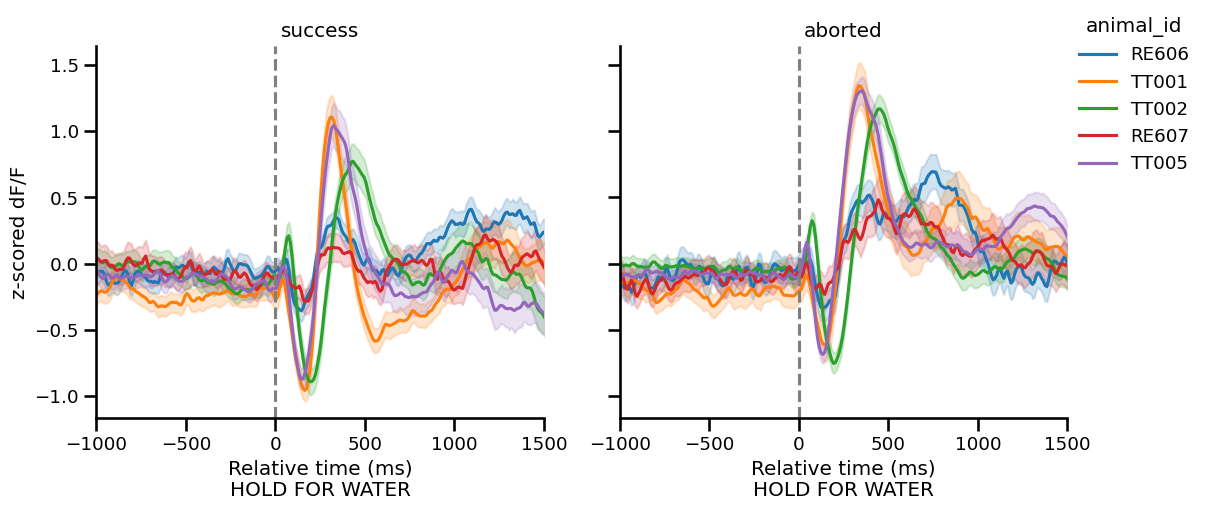

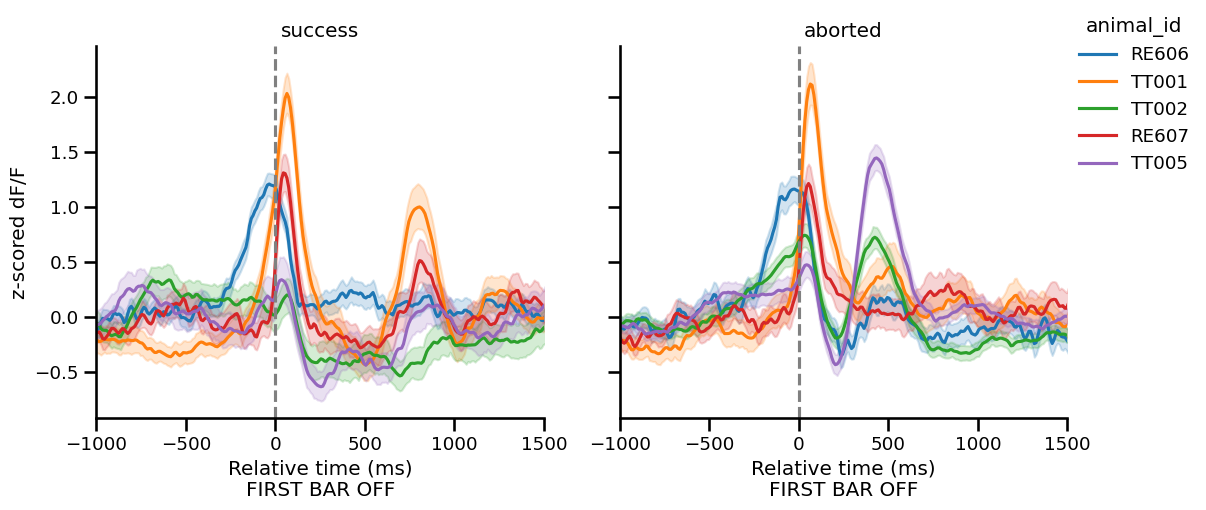

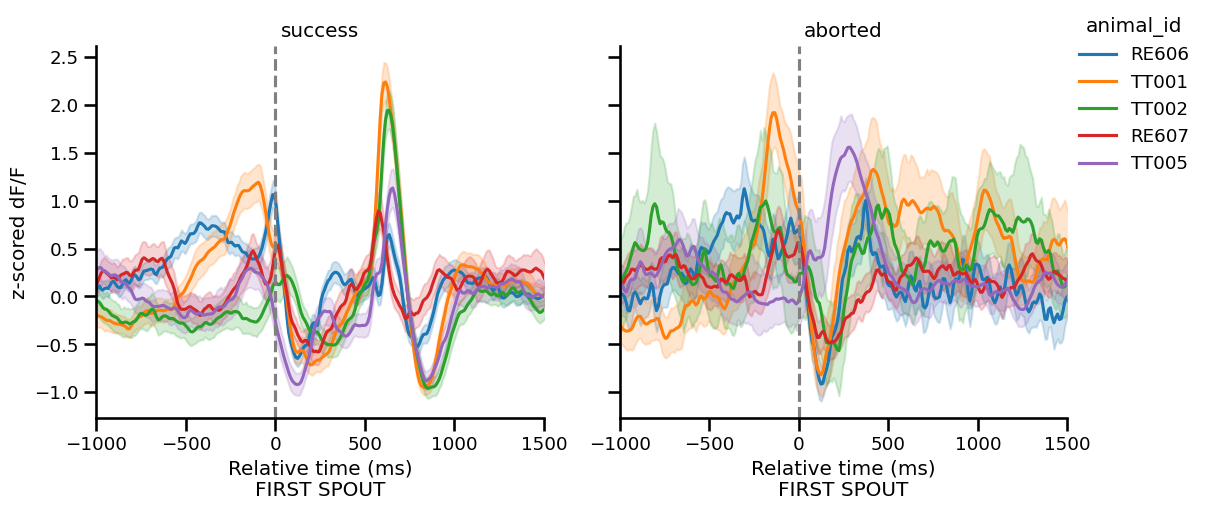

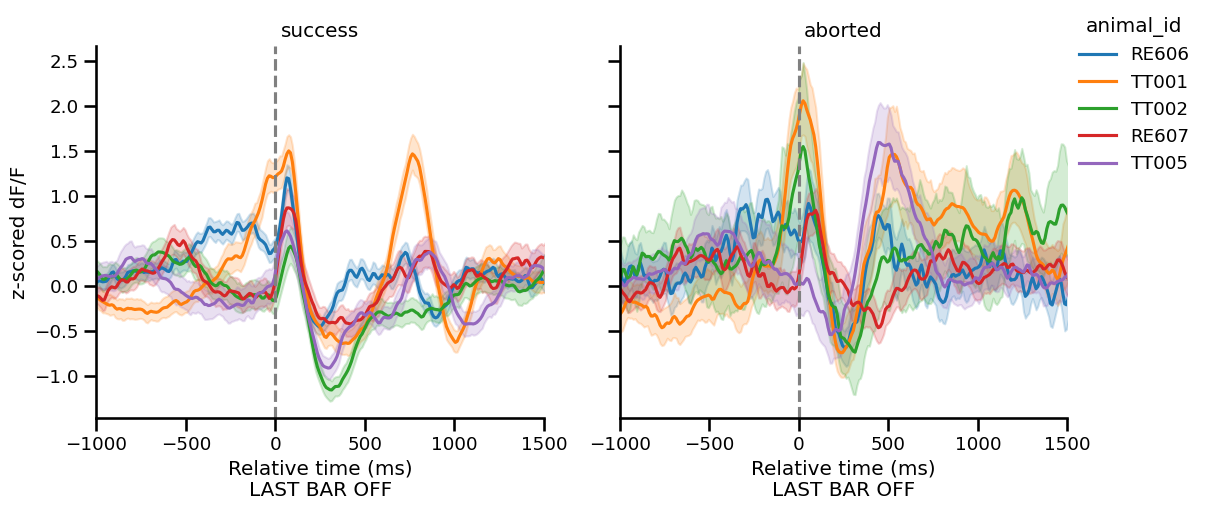

In [7]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

for v in vars_to_plot:
    fig = plot_subject_average(ds_combined, animal_id, v)
    fig.savefig(f'figures/ACh_subjecct_average_{v}.png', bbox_inches='tight')